# ResNet Experiments

Here we train the ResNet network and a ResNet network with Octave Convolution layers on the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [1]:
import os
import time
import random
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets

In [2]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

After that, we have to organize the `tiny-imagenet-200/val` to match the format of the `tiny-imagenet-200/train` directory, or else things break in annoying ways. To do this, run the script `./organize_val_imgs.sh` from the project directory. After that, we suggest you verify that the `val` and `train` directories are structured identically.

Further about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [3]:
data_dir = 'tiny-imagenet-200/'

In [4]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [5]:
# Create mini datasets for quick debugging

num_mini_samples = 100
for x in ['train', 'val']:
    mini_indices = random.sample(range(len(image_datasets[x])), k=num_mini_samples)
    mini_sampler = torch.utils.data.SubsetRandomSampler(mini_indices)
    dataloaders[x + '_mini'] = torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                            shuffle=False, num_workers=4,
                                                            sampler=mini_sampler)
    dataset_sizes[x + '_mini'] = dataloaders[x + '_mini'].batch_size * len(dataloaders[x + '_mini'])

print("Number of examples in train_mini: {}".format(dataset_sizes['train_mini']))
print("Number of examples in train_val: {}".format(dataset_sizes['val_mini']))

Number of examples in train_mini: 100
Number of examples in train_val: 100


In [45]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 224, 224])
Image class: 18


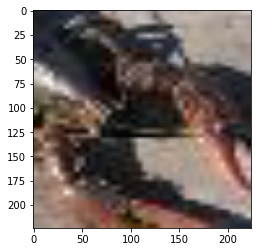

In [8]:
sample = image_datasets['train'][9402]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

In [10]:
# Make sure validation dataset is loaded properly
for inputs, labels in dataloaders["val"]:
    print("Validation minibatch labels: {}".format(labels))
    assert torch.sum(labels) != 0, "All validation labels are 0. Did you run organize_val_imgs.sh?"
    break

Validation minibatch labels: tensor([ 70,  42, 145, 111, 141, 169, 173,  88, 130,  87, 196,  21,  15, 176,
          5,  16])


### Memory Profiling tools

In [5]:
import gc
import sys
import operator as op
from functools import reduce

"""Code largely taken from  https://discuss.pytorch.org/t/how-to-debug-causes-of-gpu-memory-leaks/6741/8. Should print out the allocated memory for each of our tensors."""

def sizeof_fmt(num, suffix='B'):
    """
    Helper function to get human-readable bytes
    From https://stackoverflow.com/questions/1094841/reusable-library-to-get-human-readable-version-of-file-size
    """
    for unit in ['','K','M','G','T','P','E','Z']:
        if abs(num) < 1024.0:
            return "%3.5f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

def print_mem_tensors(verbose=False):
    """Prints stats about Pytorch's memory usage"""
    total_tensors = 0
    total_elems = 0
    total_bytes = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                total_tensors += 1
                total_elems += obj.nelement()
                total_bytes += obj.element_size() * obj.nelement() # Size of tensor elements
                total_bytes += sys.getsizeof(obj) # Tensor overhead
                if verbose:
                    print(obj.nelement(), type(obj), obj.size())
        except:
            pass
    human_bytes = sizeof_fmt(total_bytes)
    print("In-memory tensors: {}, num_elements: {}, bytes: {}".format(total_tensors, total_elems, human_bytes))
    return total_tensors, total_elems, total_bytes

## Training Vanilla ResNet

In [6]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_model(model, criterion, optimizer, save_path, log_file=None, scheduler=None, 
                num_epochs=25, train_name='train', val_name='val', verbose_mem=False):
    """
    
    Parameters:
        model (Pytorch model): the model to train
        criterion (function): the loss function to optimize
        optimizer: a Pytorch optimizer object (e.g. Adam or SGD)
        save_path (string): the file to write the best model weights to at every validation step
        log_file (string): the file to write training stats (loss, accuracy history) to
        scheduler: learning rate schduler
        num_epochs (int): number of epochs to train
        train_name (string): can be set to 'train_mini' to train on mini set.
        val_name (string): can be set to 'val_mini' to validate on mini set
        
    Returns:
        The model with highest validation accuracy from our training history
    """
    since = time.time()

    model.to(device=device, dtype=dtype)    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # clear log_file:
    if log_file:
        open(log_file, 'w').close()
        with open(log_file, 'a') as f:
            f.write("Using optimizer: {}\n\n".format(optimizer))
    print("Using optimizer: {}\n\n".format(optimizer))

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_name, val_name]:
            if phase == train_name:
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            iter_count = 0
            for inputs, labels in dataloaders[phase]:
#                 print("Iterating over batch of size {}".format(len(inputs)))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_name):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_name:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Print memory profiling stats
                if iter_count % 2500 == 0:
                    print("Iteration is {}".format(iter_count))
                    print_mem_tensors()
                    print()
                iter_count += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print and log training stats
            epoch_summary = 'Epoch: {}, {} Loss: {:.4f} Acc: {:.4f}'.format(
                epoch, phase, epoch_loss, epoch_acc)
            print(epoch_summary)
            if log_file:
                with open(log_file, "a") as f:
                    f.write(epoch_summary + "\n")

            # deep copy the best model, save weights to file
            if phase == val_name and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), save_path)
                print("Saved best model to {}".format(save_path))

        print()

    # Print and log timing stats
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    if log_file:
        with open(log_file, "a") as f:
            f.write('Training complete in {:.0f}m {:.0f}s\n'.format(
                    time_elapsed // 60, time_elapsed % 60))
            f.write('Best val Acc: {:4f}\n'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
resnet = torchvision.models.resnet18(num_classes=200, pretrained=False)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 100 # training?
#momentum = 0.9 # Lol fuggit, Adam -John
learning_rate = 1e-4 # ResNet Paper
reg = 1e-4 # Resnet paper is 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # OctConv paper

In [14]:
# Train on a mini dataset to debug
# The training accuracy should improve, and the val accuracy should be roughly random guessing
mini_epochs = 1 if device == 'cpu' else 5
mini_model = train_model(resnet, loss_fn, optimizer, 'saved_models/mini_resnet18.pth', 'logs/mini_resnet18.txt', scheduler=scheduler, num_epochs=mini_epochs, train_name='train_mini', val_name='val_mini')

Using optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0.0001
)


Epoch 0/4
----------
Iteration is 0
In-memory tensors: 380, num_elements: 48297707, bytes: 184.26786MB



/opt/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Epoch: 0, train_mini Loss: 5.3941 Acc: 0.0100
Iteration is 0
In-memory tensors: 381, num_elements: 48297708, bytes: 184.26793MB

Epoch: 0, val_mini Loss: 5.6081 Acc: 0.0100
Saved best model to saved_models/mini_resnet18.pth

Epoch 1/4
----------
Iteration is 0
In-memory tensors: 391, num_elements: 51308288, bytes: 195.75315MB

Epoch: 1, train_mini Loss: 4.6104 Acc: 0.0200
Iteration is 0
In-memory tensors: 382, num_elements: 48297709, bytes: 184.26801MB

Epoch: 1, val_mini Loss: 6.2932 Acc: 0.0100

Epoch 2/4
----------
Iteration is 0
In-memory tensors: 384, num_elements: 48899825, bytes: 186.56505MB

Epoch: 2, train_mini Loss: 4.1761 Acc: 0.0600
Iteration is 0
In-memory tensors: 390, num_elements: 50706173, bytes: 193.45618MB

Epoch: 2, val_mini Loss: 7.0338 Acc: 0.0000

Epoch 3/4
----------
Iteration is 0
In-memory tensors: 382, num_elements: 48297709, bytes: 184.26801MB

Epoch: 3, train_mini Loss: 3.9714 Acc: 0.0900
Iteration is 0
In-memory tensors: 384, num_elements: 48899825, bytes:

In [7]:
def evaluate_model(model, criterion, val_name='val'):
    # Each epoch has a training and validation phase
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for i, (inputs, labels) in enumerate(dataloaders[val_name]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[val_name]
    epoch_acc = running_corrects.double() / dataset_sizes[val_name]

    print('Loss on {}: {:.4f} Acc: {:.4f}'.format(
        val_name, epoch_loss, epoch_acc))

In [16]:
evaluate_model(resnet, loss_fn, val_name='val_mini')

Loss on val_mini: 7.5662 Acc: 0.0300


## Training the Big Model

In [8]:
# Train the actual big model
resnet = torchvision.models.resnet18(num_classes=200, pretrained=False)
loss_fn = nn.CrossEntropyLoss()

num_epochs = 100 # training?
#momentum = 0.9 # Lol fuggit, Adam -John
learning_rate = 1e-4 # ResNet Paper
reg = 1e-4 # Resnet paper is 1e-4
optimizer = torch.optim.Adam(resnet.parameters(), lr=learning_rate, weight_decay=reg)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) # OctConv paper

best_resnet_path = 'saved_models/reg_res18.pth'
best_model = train_model(resnet, 
                         loss_fn, 
                         optimizer,
                         best_resnet_path, 
                         log_file='logs/reg_res18.txt', 
                         scheduler=scheduler, 
                         num_epochs=num_epochs,
                         verbose_mem=True
                        )

Using optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 0.0001
    weight_decay: 0.0001
)


Epoch 0/99
----------
Iteration is 0
In-memory tensors: 375, num_elements: 47547386, bytes: 181.40491MB



/opt/anaconda3/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:100: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Iteration is 5000
In-memory tensors: 375, num_elements: 47547386, bytes: 181.40491MB

Epoch: 0, train Loss: 4.5976 Acc: 0.0686
Iteration is 0
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Epoch: 0, val Loss: 4.0225 Acc: 0.1335
Saved best model to saved_models/reg_res18.pth

Epoch 1/99
----------
Iteration is 0
In-memory tensors: 382, num_elements: 54772779, bytes: 208.96827MB

Iteration is 2500
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Iteration is 5000
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Epoch: 1, train Loss: 4.0089 Acc: 0.1417
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 1, val Loss: 3.4645 Acc: 0.2194
Saved best model to saved_models/reg_res18.pth

Epoch 2/99
----------
Iteration is 0
In-memory tensors: 378, num_elements: 49955851, bytes: 190.59275MB

Iteration is 2500
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Iteration is 5000
In-mem

Epoch: 17, train Loss: 2.4797 Acc: 0.4197
Iteration is 0
In-memory tensors: 385, num_elements: 57181244, bytes: 218.15610MB

Epoch: 17, val Loss: 2.0668 Acc: 0.4994
Saved best model to saved_models/reg_res18.pth

Epoch 18/99
----------
Iteration is 0
In-memory tensors: 378, num_elements: 49955851, bytes: 190.59275MB

Iteration is 2500
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Iteration is 5000
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Epoch: 18, train Loss: 2.4426 Acc: 0.4288
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 18, val Loss: 2.0247 Acc: 0.5115
Saved best model to saved_models/reg_res18.pth

Epoch 19/99
----------
Iteration is 0
In-memory tensors: 380, num_elements: 52364315, bytes: 199.78051MB

Iteration is 2500
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Iteration is 5000
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Epoch: 19, train L

Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 34, val Loss: 1.7629 Acc: 0.5727

Epoch 35/99
----------
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 35, train Loss: 1.9360 Acc: 0.5332
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 35, val Loss: 1.7755 Acc: 0.5724

Epoch 36/99
----------
Iteration is 0
In-memory tensors: 383, num_elements: 54772780, bytes: 208.96834MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 36, train Loss: 1.9084 Acc: 0.5380
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 36, val Loss: 1.7533 A

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 52, train Loss: 1.5200 Acc: 0.6285
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 52, val Loss: 1.7589 Acc: 0.5960

Epoch 53/99
----------
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 2500
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Iteration is 5000
In-memory tensors: 376, num_elements: 47547387, bytes: 181.40499MB

Epoch: 54, train Loss: 1.4728 Acc: 0.6355
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 54, val Loss: 1.7494 Acc: 0.5987

Epoch 55/99
----------
Iteration is 0
In-memor

Epoch: 70, val Loss: 1.7476 Acc: 0.6121

Epoch 71/99
----------
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 71, train Loss: 1.1459 Acc: 0.7193
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 71, val Loss: 1.7425 Acc: 0.6160

Epoch 72/99
----------
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 72, train Loss: 1.1367 Acc: 0.7221
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 72, val Loss: 1.7576 Acc: 0.6140

Epoch 73/99
----------
Iteration is 0
In-memory tensors: 377, num_eleme

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 89, train Loss: 0.9614 Acc: 0.7668
Iteration is 0
In-memory tensors: 381, num_elements: 52364316, bytes: 199.78058MB

Epoch: 89, val Loss: 1.7467 Acc: 0.6180

Epoch 90/99
----------
Iteration is 0
In-memory tensors: 379, num_elements: 49955852, bytes: 190.59282MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 90, train Loss: 0.9667 Acc: 0.7676
Iteration is 0
In-memory tensors: 381, num_elements: 52364316, bytes: 199.78058MB

Epoch: 90, val Loss: 1.7367 Acc: 0.6199

Epoch 91/99
----------
Iteration is 0
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 2500
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Iteration is 5000
In-memory tensors: 377, num_elements: 47547388, bytes: 181.40506MB

Epoch: 91, train Loss: 0.9

## Generate Training Plots

In [29]:
%load_ext autoreload
%autoreload 2
import log_utils
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


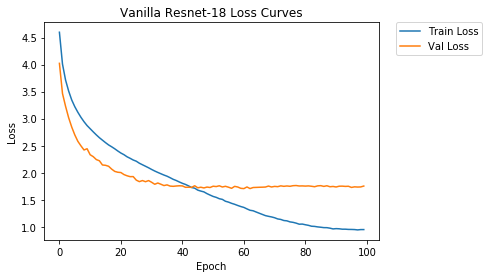

In [41]:
history = log_utils.get_history('logs/reg_res18.txt')

fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(r'Vanilla Resnet-18 Loss Curves')

x1 = range(len(history["train_losses"]))
plt.plot(x1, history["train_losses"], label="Train Loss")
plt.plot(x1, history["val_losses"], label="Val Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

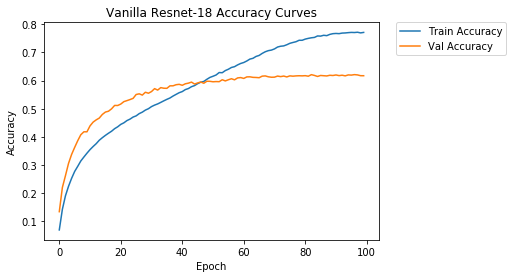

In [40]:
fig, ax = plt.subplots()
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title(r'Vanilla Resnet-18 Accuracy Curves')

x1 = range(len(history["train_accuracies"]))
plt.plot(x1, history["train_accuracies"], label="Train Accuracy")
plt.plot(x1, history["val_accuracies"], label="Val Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Test Set Evaluation

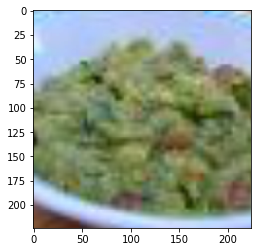

In [77]:
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])
imshow(test_dataset[2][0]) # sorts alphabetically, this is test_10
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [65]:
import os
test_dir = os.path.join(data_dir, 'test/images')
test_names = [f for f in os.listdir(test_dir) if f.endswith(".JPEG")]
test_names.sort()
print(test_names[:10]) # also sorts alphabetically
print(len(test_names))

['test_0.JPEG', 'test_1.JPEG', 'test_10.JPEG', 'test_100.JPEG', 'test_1000.JPEG', 'test_1001.JPEG', 'test_1002.JPEG', 'test_1003.JPEG', 'test_1004.JPEG', 'test_1005.JPEG']
10000


In [78]:
train_dir = os.path.join(data_dir, 'train')
class_names = [o for o in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir,o))]
class_names.sort()
print(len(class_names))
print(class_names[:5])

class_names[178]

200
['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640']


'n07583066'

In [88]:
from tqdm import tqdm
test_output_path = 'logs/test_predictions.txt'

best_model.eval()
with open(test_output_path, "w") as prediction_file:
    for i, (inputs, labels) in tqdm(enumerate(testloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = best_model(inputs)
            _, preds = torch.max(outputs, 1)
            img_name = test_names[i]
            pred_class = class_names[preds.item()]
            prediction_file.write(img_name + " " + pred_class + "\n")

10000it [01:25, 117.27it/s]
